In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
import tensorflow_datasets as tfds



### Extra utilities

In [4]:
# For file handling 

import os
import shutil

# Progress bar 
from tqdm.auto import tqdm, trange

In [4]:
# # For stl10 image dataset

# batch_size = 32
# num_classes = 4
# num_epochs = 50
# # num_epochs = 1
# # num_epochs = 10
# total_timesteps = 1000
# norm_groups = 8
# learning_rate = 2e-4

# img_size = 64
# img_channels = 3
# clip_min = -1.0
# clip_max = 1.0

# first_conv_channels = 64
# channel_multiplier = [1, 2, 4, 8]
# widths = [first_conv_channels * mult for mult in channel_multiplier]
# has_attention = [False, False, True, True]
# num_res_blocks = 2

In [5]:
# For stl10 image dataset

batch_size = 32
num_classes = 4
num_epochs = 50
# num_epochs = 1
# num_epochs = 10
total_timesteps = 1000
norm_groups = 8
learning_rate = 2e-4

img_size = 32
img_channels = 3
clip_min = -1.0
clip_max = 1.0

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2

In [6]:
# show images with labels 

def show_image(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()
    
def show_examples(images, labels, count=5):
    for i in range(count):
        show_image(images[i], labels[i]) 

In [7]:
data_dir = "/kaggle/working/"

In [8]:
# # Load the STL-10 dataset with specified classes
# dataset, info = tfds.load('stl10', split='train', as_supervised=True, with_info=True, data_dir=data_dir)

# # Show examples from the filtered dataset
# tfds.show_examples(dataset, info)

# # Extract images and labels separately
# image_dataset = dataset.map(lambda x, y: x)
# label_dataset = dataset.map(lambda x, y: y)

# # Print dataset shapes
# print("Shape of image dataset:", image_dataset.element_spec)
# print("Shape of label dataset:", label_dataset.element_spec)



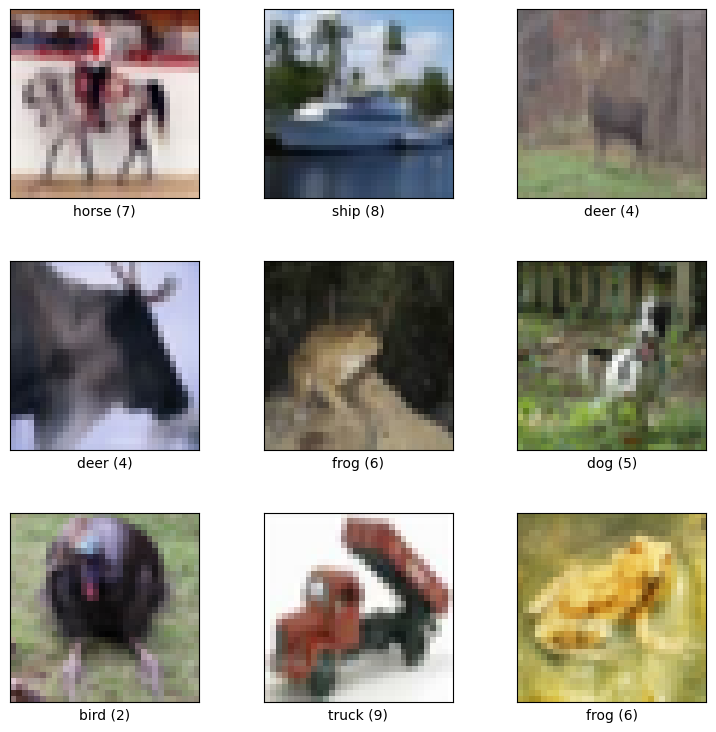

Shape of image dataset: TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)
Shape of label dataset: TensorSpec(shape=(), dtype=tf.int64, name=None)


In [9]:
# Load the STL-10 dataset with specified classes
dataset, info = tfds.load('cifar10', split='train', as_supervised=True, with_info=True, data_dir=data_dir)

# Show examples from the filtered dataset
tfds.show_examples(dataset, info)

# Extract images and labels separately
image_dataset = dataset.map(lambda x, y: x)
label_dataset = dataset.map(lambda x, y: y)

# Print dataset shapes
print("Shape of image dataset:", image_dataset.element_spec)
print("Shape of label dataset:", label_dataset.element_spec)

In [10]:
# Initialize empty lists to collect elements
image_list = []
label_list = []

# Iterate over the dataset and collect elements
for image, label in zip(image_dataset, label_dataset):
    image_list.append(image.numpy())
    label_list.append(label.numpy())

# Convert the lists to numpy arrays
image_dataset_array = np.array(image_list)
label_dataset_array = np.array(label_list)

# Check the types
print(type(image_dataset_array))
print(type(label_dataset_array))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
# Filter the images needed only. airplanes, birds, cars, cats

# Define the labels you want to include
included_labels = [0, 1, 2, 3]

# Create a boolean mask to filter images based on labels
mask = np.isin(label_dataset_array, included_labels)

# Filter images and labels based on the mask
filtered_images = image_dataset_array[mask]
filtered_labels = label_dataset_array[mask]

# Check the shape of the filtered images
print("Filtered images shape:", filtered_images.shape)
print("Filtered labels shape:", filtered_labels.shape)

Filtered images shape: (20000, 32, 32, 3)
Filtered labels shape: (20000,)


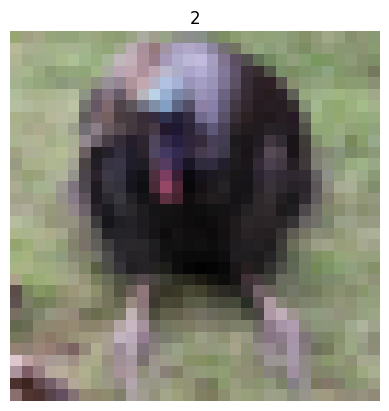

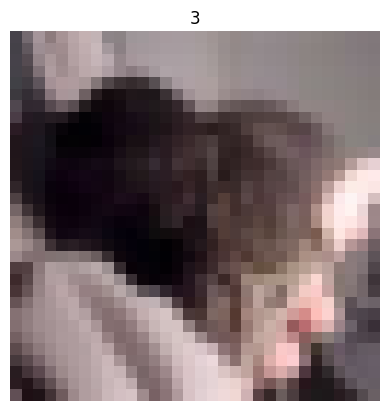

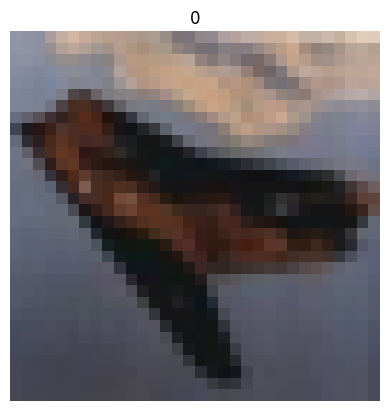

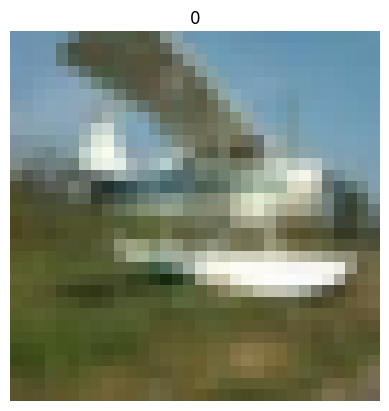

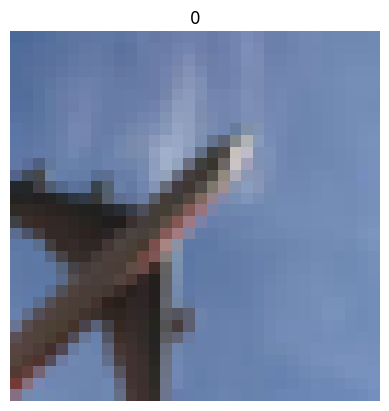

In [12]:
# show filtered images

show_examples(filtered_images, filtered_labels)

In [13]:
# One hot encoding of labels.

num_classes = 4
# one_hot_filtered_labels = tf.one_hot(filtered_labels, num_classes)
one_hot_filtered_labels = np.eye(num_classes)[filtered_labels]
print(one_hot_filtered_labels.shape)

(20000, 4)


In [14]:
def augment(img):
    # Randomly flip image horizontally : 
    return tf.image.random_flip_left_right(img)

def resize_and_rescale(img, size):
    """Resizse image to the size given above and rescale it in range [-1.0, 1.0]"""
    
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    crop_size = tf.minimum(height, width)
    
    # Croping :
    img = tf.image.crop_to_bounding_box(img, (height-crop_size)//2, (width-crop_size)//2, crop_size, crop_size)
    
    # Resizing :
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size = size, antialias = True)
    
    #  Rescaling : 
    img = img/127.5 -1
    img = tf.clip_by_value(img, clip_min, clip_max)
    return img

def train_preprocessing(img):
    img = resize_and_rescale(img, size = (img_size, img_size))
    img = augment(img)
    return img

def batch_train_preprocessing(images):
    processed_images = tf.map_fn(train_preprocessing, images, dtype=tf.float32)
    return processed_images

In [15]:
image_tensors = tf.convert_to_tensor(filtered_images)
type(image_tensors)

tensorflow.python.framework.ops.EagerTensor

In [16]:
processed_filtered_images = batch_train_preprocessing(image_tensors)

In [17]:
class GaussianDiffusion:
    """Diffuse the data : 
    Args : 
        beta_start : start value of the scheduled variance
        beta_end : end value of the scheduled variance
        timesteps : Number of timesteps for forward diffusion process
    """
    
    def __init__(
        self,
        beta_start = 1e-4,
        beta_end = 0.02,
        timesteps = 1000,
        clip_min = -1.0,
        clip_max = 1.0,
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max
        
        # Calculations :
        
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype = np.float64
        )
        self.num_timesteps = timesteps
        
        alphas = 1- betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0,alphas_cumprod[:-1]) # ?
        
        self.betas = tf.constant(betas, dtype = tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype = tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype = tf.float32)
        
        # Calculations of q(x_t | x_{t-1}) and others :
        self.sqrt_alphas_cumprod = tf.constant(np.sqrt(alphas_cumprod), dtype = tf.float32)
        
        self.sqrt_one_minus_alphas_cumprod = tf.constant(np.sqrt(1.0 - alphas_cumprod), dtype = tf.float32)
        
        self.log_one_minus_alphas_cumprod = tf.constant(np.log(1.0 - alphas_cumprod), dtype = tf.float32)
        
        self.sqrt_recip_alphas_cumprod = tf.constant(np.sqrt(1.0 / alphas_cumprod), dtype = tf.float32)
        
        self.sqrt_recipm1_alphas_cumprod =  tf.constant(np.sqrt(1.0 / alphas_cumprod - 1), dtype = tf.float32)
        
        # Calculations for the posterior q(x_{t-1} | x_t, x_0) : 
        posterior_variance = betas*(1.0 - alphas_cumprod_prev)/(1.0 - alphas_cumprod)
        self.posterior_variance = tf.constant(np.log(np.maximum(posterior_variance, 1e-20)), dtype = tf.float32)
        
        # log of posterior variance but also keep in mind the case of log(0) as variance starts from 0 :
        self.posterior_log_variance_clipped = tf.constant(np.log(np.maximum(posterior_variance, 1e-20)), dtype = tf.float32)
        
        self.posterior_mean_coef1 = tf.constant(betas*np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod), dtype = tf.float32)
        self.posterior_mean_coef2 = tf.constant(np.sqrt(alphas)*(1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod), dtype = tf.float32)
        
    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps provide and
        then reshape it to [batch_size, 1, 1, 1,]  # ?
        """
        
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])
    
    def q_mean_variance(self, x_start, t):
        """Extract the mean and variance of the current timestep.
        """
        
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape)*x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start_shape)
        
        return mean, variance, log_variance
    
    def q_sample(self, x_start, t, noise):
        """Diffuse the data"""
        
        x_start_shape = tf.shape(x_start)
        return (self._extract(self.sqrt_alphas_cumprod, t, x_start_shape)*x_start
                + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)*noise)
    
    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape)*x_t
               - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape)*noise) # ?
    
    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and the variance of the diffusion 
        posterior q(x_{t-1} | x_t, x_0).
        """
        x_t_shape = tf.shape(x_t)
        posterior_mean = self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t_shape)
        
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    def p_mean_variance(self, pred_noise, x, t, clip_denoised = True):
        x_recon = self.predict_start_from_noise(x, t=t, noise = pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)
        
        model_mean, posterior_variance,  posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance
    
    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model."""
        
        model_mean, _ , model_log_variance = self.p_mean_variance(pred_noise=pred_noise, x=x, t=t, clip_denoised=clip_denoised)
        noise = tf.random.normal(shape = x.shape, dtype = x.dtype)
        
        non_zero_mask = tf.reshape(
            1-tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        
        return model_mean + non_zero_mask * tf.exp(0.5*model_log_variance) * noise

In [18]:
# kernel initializer to be used :
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(scale, mode="fan_avg", distribution = "uniform")

class AttentionBlock(layers.Layer):
    """Applies self attention"""
    
    def __init__(self, units, groups = 8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)
        
        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32)**(-0.5)
        
        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)
        
        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k)*scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height*width])
        
        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size , height, width, height, width])
        
        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        
        return inputs + proj
    
class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim//2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype = tf.float32) * -self.emb)
    
    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb
def TextEmbedding(inputs):
    text_emb = inputs
    return text_emb
    
    
def ResidualBlock(width, groups = 8, activation_fn = keras.activations.swish):
    def apply(inputs):
        x, t, text = inputs
        input_width = x.shape[3]
        
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1, kernel_initializer=kernel_init(1.0))(x)
        
        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[:,None,None,:]
        
#         text_emb = activation_fn(text)
#         text_emb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(text)[:,None,None,:]
#         text_emb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(text)
        text_emb = activation_fn(text)
        text_emb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(text_emb)
        
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(width, kernel_size=3, padding='same', kernel_initializer=kernel_init(1.0))(x)
        
        x = layers.Add()([x, temb])
        x = layers.Add()([x, text_emb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        
        x = layers.Conv2D(width, kernel_size=3,padding='same', kernel_initializer=kernel_init(0.0))(x)
        x = layers.Add()([x, residual])
        return x
    
    return apply

def DownSample(width):
    def apply(x):
        x = layers.Conv2D(width, kernel_size=3, strides=2, padding='same', kernel_initializer=kernel_init(1.0))(x)
        return x
    return apply

def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = layers.Conv2D(width, kernel_size=3, padding='same', kernel_initializer=kernel_init(1.0))(x)
        return x
    return apply

def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(units, activation=activation_fn, kernel_initializer=kernel_init(1.0))(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb
    return apply

def TextMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        text_temb = layers.Dense(units, activation=activation_fn, kernel_initializer=kernel_init(1.0))(inputs)
        text_temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(text_temb)
        return text_temb
    return apply

def build_model(img_size, img_channels, widths, has_attention, num_res_blocks=2, norm_groups=8, interpolation="nearest", activation_fn=keras.activations.swish):
    image_input = layers.Input(shape=(img_size, img_size, img_channels), name="image_input")
    time_input = layers.Input(shape=(), name="time_input")
    text_input = layers.Input(shape=(4,), name="text_input")
    
    x = layers.Conv2D(first_conv_channels, kernel_size = (3,3), padding='same', kernel_initializer=kernel_init(1.0))(image_input)
    
    temb = TimeEmbedding(dim=first_conv_channels*4)(time_input)
    temb = TimeMLP(units=first_conv_channels*4, activation_fn=activation_fn)(temb)
    
    text_emb = TextEmbedding(text_input)
    text_emb = TextMLP(units=first_conv_channels*4, activation_fn=activation_fn)(text_emb)
    
    skips = [x]
    
    # DownBlock :
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(width=widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb, text_emb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)
        
        if widths[i]!=widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)
    # MiddleBlock :
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb, text_emb])
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb, text_emb])
    
    # UpBlock :
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(width=widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb, text_emb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            
        if i!=0:
            x = UpSample(widths[i], interpolation=interpolation)(x)
    
    # End Block :
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = layers.Conv2D(3, (3, 3), padding='same', kernel_initializer=kernel_init(0.0))(x)
    model = keras.models.Model([image_input, time_input, text_input], x, name="unet")
    
    return model
    
    
        

# Training of diffusion model

In [19]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema
    
    def apply_random_mask(self, text_embeddings, mask_probability=0.5):
        mask = tf.random.uniform(tf.shape(text_embeddings)) < mask_probability
        mask = tf.cast(mask, dtype=text_embeddings.dtype)
        masked_embeddings = mask * text_embeddings
        return masked_embeddings
    
    def train_step(self, data):
        images, text_embeddings = data[0]  # Unpack the data
        masked_text_embeddings = self.apply_random_mask(text_embeddings, mask_probability=0.9)
        batch_size = tf.shape(images)[0]
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)
        
        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
            images_t = self.gdf_util.q_sample(images, t, noise)
            pred_noise = self.network([images_t, t, masked_text_embeddings], training=True)  # Pass text_embeddings
            loss = self.loss(noise, pred_noise)
        
        gradients = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))
        
        for weights, ema_weights in zip(self.network.weights, self.ema_network.weights):
            ema_weights.assign(self.ema*ema_weights + (1-self.ema)*weights)
        
        return {'loss': loss}
    
    def generate_images(self, num_images=16):
        random_indices = tf.random.uniform((num_images,), minval=0, maxval=num_classes, dtype=tf.int32)
        text_embeddings = tf.one_hot(random_indices, num_classes)
        
        samples = tf.random.normal(shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32)
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict([samples, tt, text_embeddings], verbose=0, batch_size=num_images)
            samples = self.gdf_util.p_sample(pred_noise, samples, tt, clip_denoised=True)
        
        return samples, text_embeddings
    
    def embedding_to_name(self, embedding):
        classes = ["airplane", "car", "bird", "cat"]
        i  = tf.argmax(embedding)
        return classes[i]
    
    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5)
    ):
        generated_samples, text_embeddings = self.generate_images(num_images=num_rows * num_cols)
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            class_name = self.embedding_to_name(text_embeddings[i])
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].set_title(class_name)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].set_title(class_name)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()


In [20]:
network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)

ema_network = build_model(
    img_size=img_size,
    img_channels=img_channels,
    widths=widths,
    has_attention=has_attention,
    num_res_blocks=num_res_blocks,
    norm_groups=norm_groups,
    activation_fn=keras.activations.swish,
)


In [21]:
network.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 time_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 time_embedding (TimeEmbedd  (None, 256)                  0         ['time_input[0][0]']          
 ing)                                                                                             
                                                                                                  
 image_input (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  65792     ['time_embedding[0][0]']   

In [22]:
ema_network.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 time_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 time_embedding_1 (TimeEmbe  (None, 256)                  0         ['time_input[0][0]']          
 dding)                                                                                           
                                                                                                  
 image_input (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 dense_92 (Dense)            (None, 256)                  65792     ['time_embedding_1[0][0]'] 

In [23]:
ema_network.set_weights(network.get_weights()) # Initially the weights are the same

# Get an instance or object for Guassian Diffusion Utilities :
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

model = DiffusionModel(network=network, ema_network=ema_network, gdf_util=gdf_util, timesteps=total_timesteps)
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=learning_rate))



In [24]:
model.ema_network = load_model('/kaggle/working/models/cifar10_text_model1_ema_network')
model.network = load_model("/kaggle/working/models/cifar_10_text_model1_network")

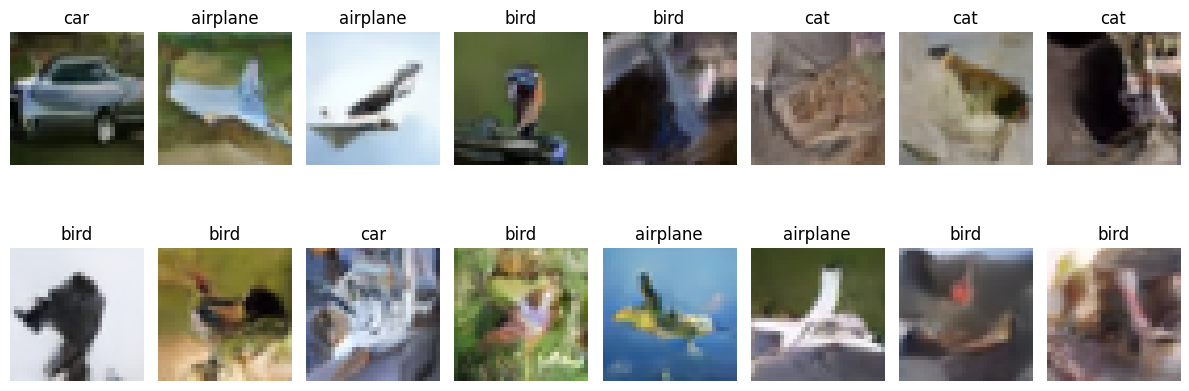

In [25]:
model.plot_images()

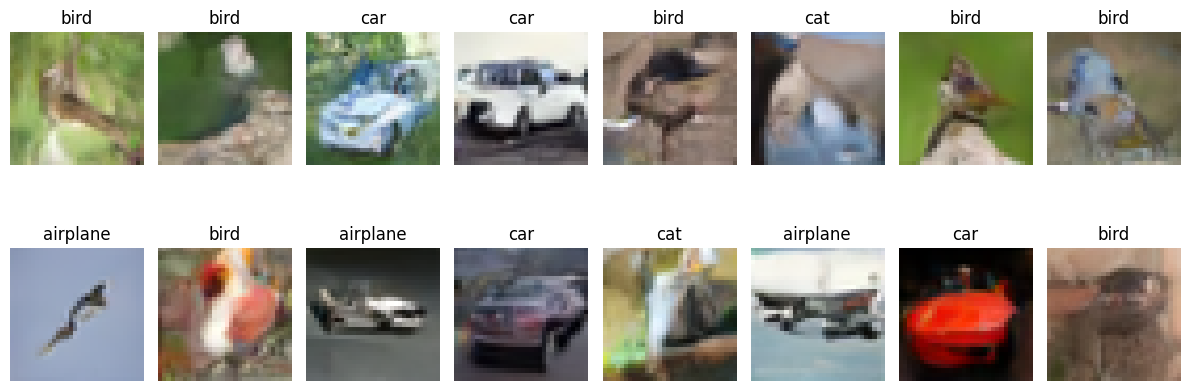

In [26]:
model.plot_images()

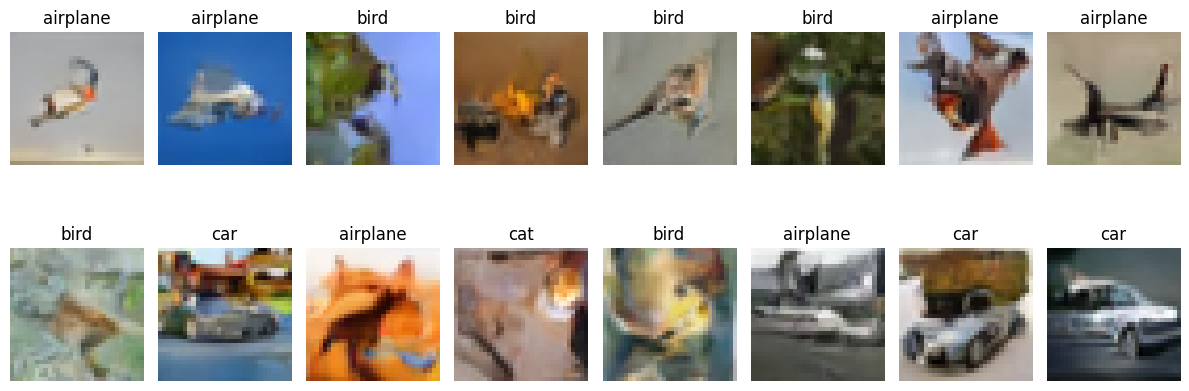

In [27]:
model.plot_images()

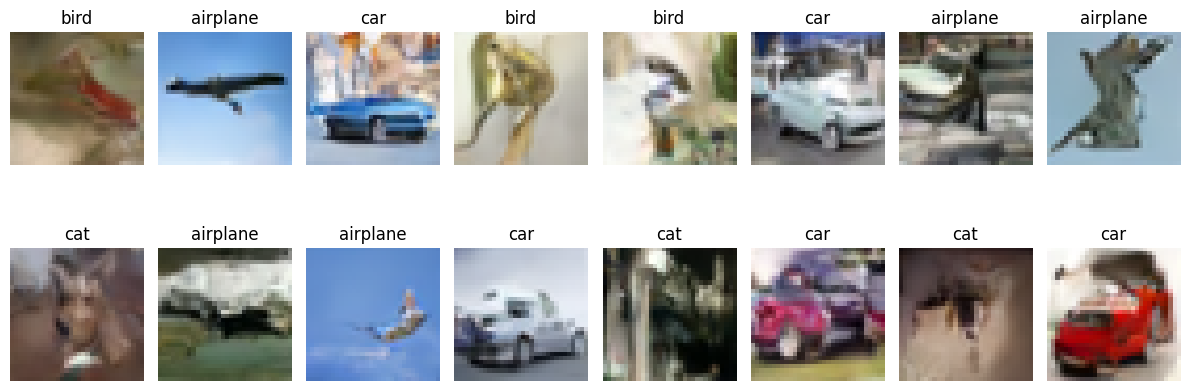

In [28]:
model.plot_images() # old

### Experiment

In [26]:
def text_to_image(model, text_embeddings):
    num_images = text_embeddings.shape[0]
    samples = tf.random.normal(shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32)

    for t in reversed(range(0, model.timesteps)):
        tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
        pred_noise = model.ema_network.predict([samples, tt, text_embeddings], verbose=0, batch_size=num_images)
        samples = model.gdf_util.p_sample(pred_noise, samples, tt, clip_denoised=True)

    return samples, text_embeddings

In [27]:
def show_image_with_labels(images, labels, figsize=(1.5, 1.5)):
    print(tf.shape(images))
    title = ["airplane", "car", "bird", "cat"]
    for i, image in enumerate(images):
        name_index = np.argmax(labels[i])
        name = title[name_index]
        plt.figure(figsize=figsize)  # Set the figure size
        plt.imshow((image + 1) / 2)
        plt.title(name)
        plt.axis('off')
        plt.show()


In [28]:
temp_text_embeddings = np.array([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1],
])

# temp_text_embeddings = np.array([
#     [0.5,0.5,0.0,0.0],
#     [0.0,0.0,0.2,0.8],
#     [0.0,1.0,0.0,1.0],
#     [1.0,0.0,0.0,1.0],
# ])
samples, _ = text_to_image(model, temp_text_embeddings)

tf.Tensor([ 4 32 32  3], shape=(4,), dtype=int32)


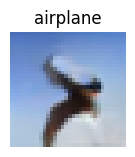

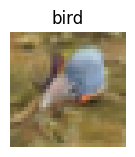

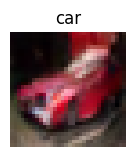

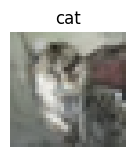

In [29]:
show_image_with_labels(samples, temp_text_embeddings)

tf.Tensor([ 4 32 32  3], shape=(4,), dtype=int32)


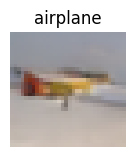

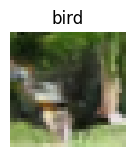

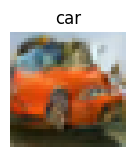

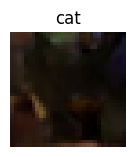

In [33]:
show_image_with_labels(samples, temp_text_embeddings)

### Data Augmentation and Reshuffling

In [46]:
# Data Augmentation
processed_filtered_images = batch_train_preprocessing(image_tensors)

In [47]:
# Reshuffling 
num_samples = len(processed_filtered_images)
shuffled_indices = np.random.permutation(num_samples)

# 1. Convert shuffled_indices to a tensor
shuffled_indices_tensor = tf.constant(shuffled_indices)

# 2. Shuffle processed_filtered_images and one_hot_filtered_labels
shuffled_processed_filtered_images = tf.gather(processed_filtered_images, shuffled_indices_tensor)
shuffled_one_hot_filtered_labels = (tf.gather(one_hot_filtered_labels, shuffled_indices_tensor)).numpy()

In [48]:
train_ds = (shuffled_processed_filtered_images, shuffled_one_hot_filtered_labels)

In [37]:
# temp_train_size = int(len(shuffled_processed_filtered_images)*0.3)
# temp_train_ds = (shuffled_processed_filtered_images[:temp_train_size], shuffled_one_hot_filtered_labels[:temp_train_size])

# Training

In [38]:
model.ema_network = load_model('/kaggle/working/models/cifar10_text_model1_ema_network')
model.network = load_model("/kaggle/working/models/cifar_10_text_model1_network")

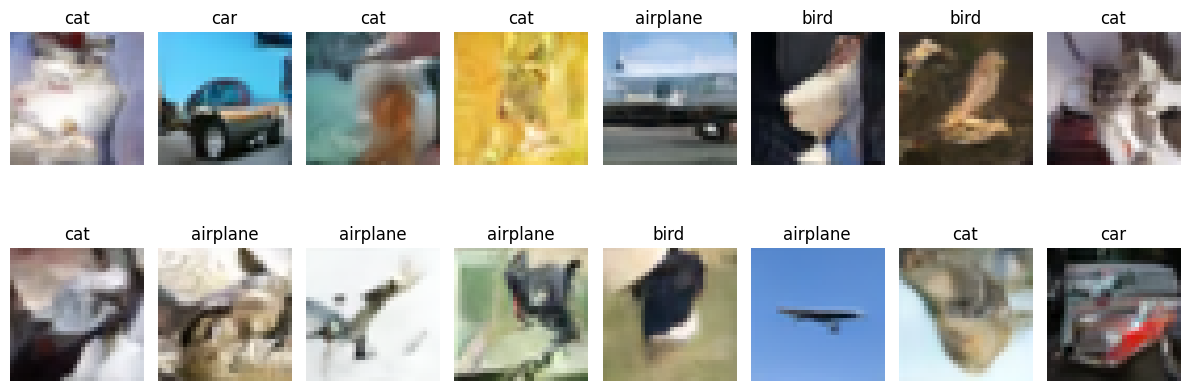

In [39]:
model.plot_images() # Model 1

In [49]:
model.fit(train_ds, epochs=num_epochs//2, batch_size=batch_size*2)

Epoch 1/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0285
Epoch 2/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0284
Epoch 3/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0289
Epoch 4/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0287
Epoch 5/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0283
Epoch 6/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0287
Epoch 7/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0284
Epoch 8/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0286
Epoch 9/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0291
Epoch 10/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0296
Epoch 11/25
313/313 [==============================] - 96s 307ms/step - loss: 0.0293
Epoch 12/25
313/313 [==============================] - 96s 307ms/step - lo

### Saving the model

In [50]:
model.ema_network.save('/kaggle/working/models/cifar10_text_model4_ema_network')
model.network.save("/kaggle/working/models/cifar_10_text_model4_network")

In [ ]:
from IPython.display import display, clear_output
import tensorflow as tf

# Assuming you have a list of TensorFlow tensors called image_tensors
for image_tensor in image_tensors[:5]:
    # Convert TensorFlow tensor to NumPy array
    image_array = image_tensor.numpy()

    # Clear the previous output
    clear_output(wait=True)

    # Display the image
    display(tf.keras.preprocessing.image.array_to_img(image_array))


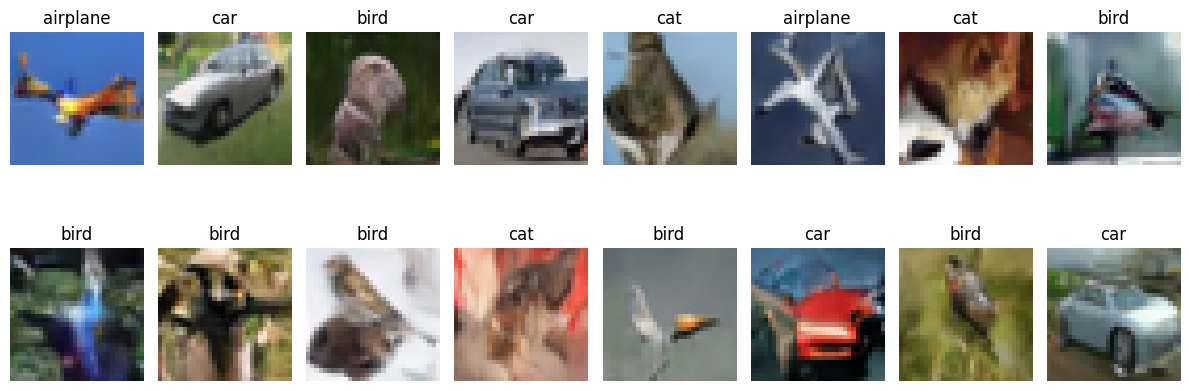

In [51]:
model.plot_images() # Model 4

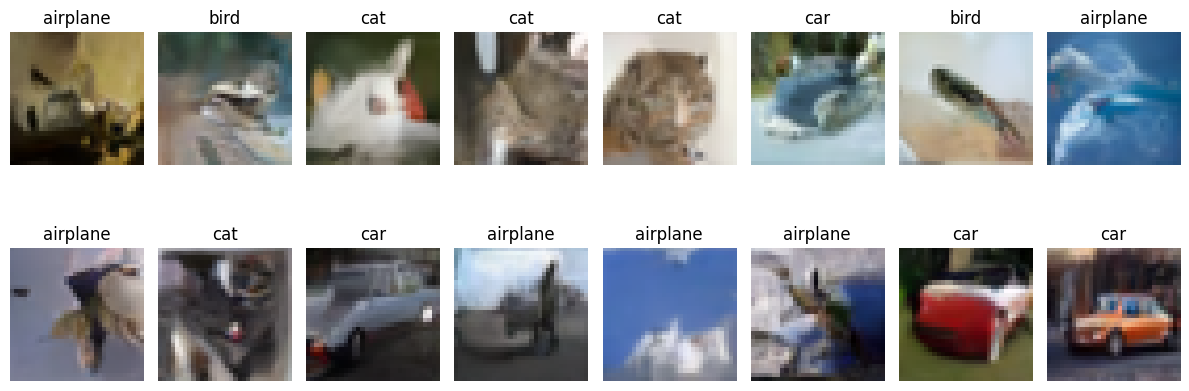

In [52]:
model.plot_images() # Model 4

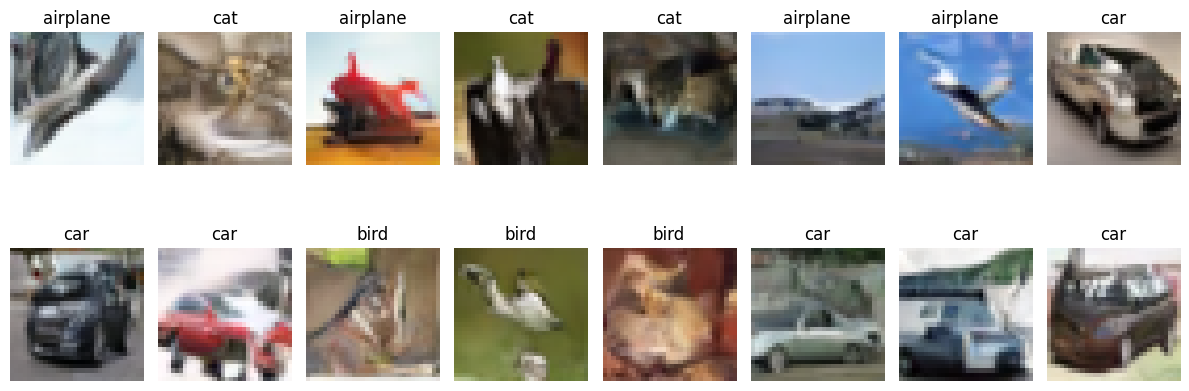

In [53]:
model.plot_images() # Model 4

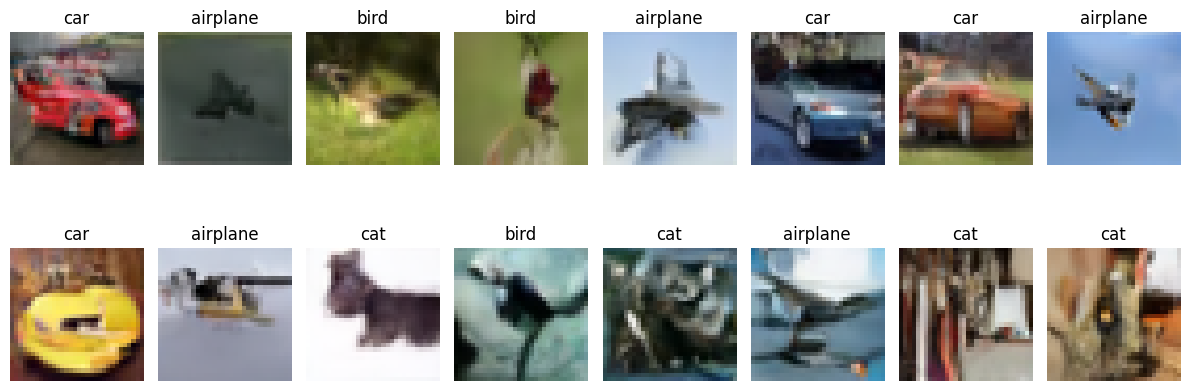

In [43]:
model.plot_images() # Model 3

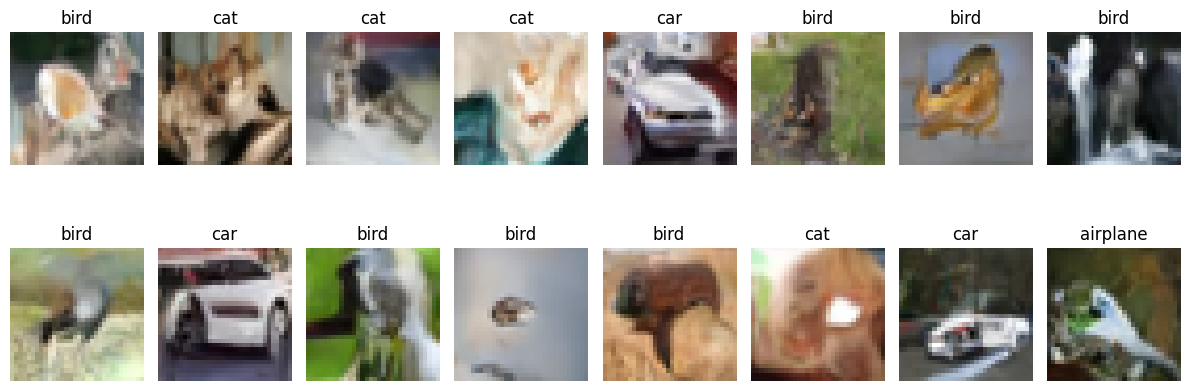

In [44]:
model.plot_images() # Model 3

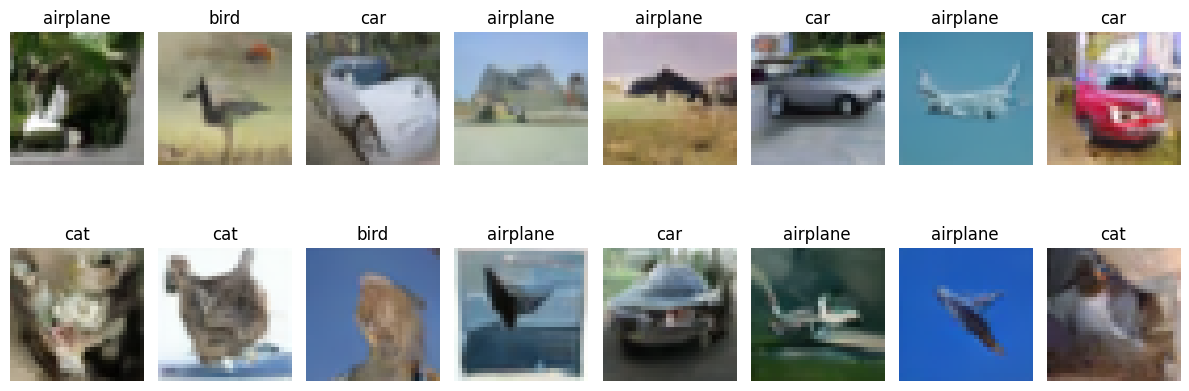

In [45]:
model.plot_images() # Model 3

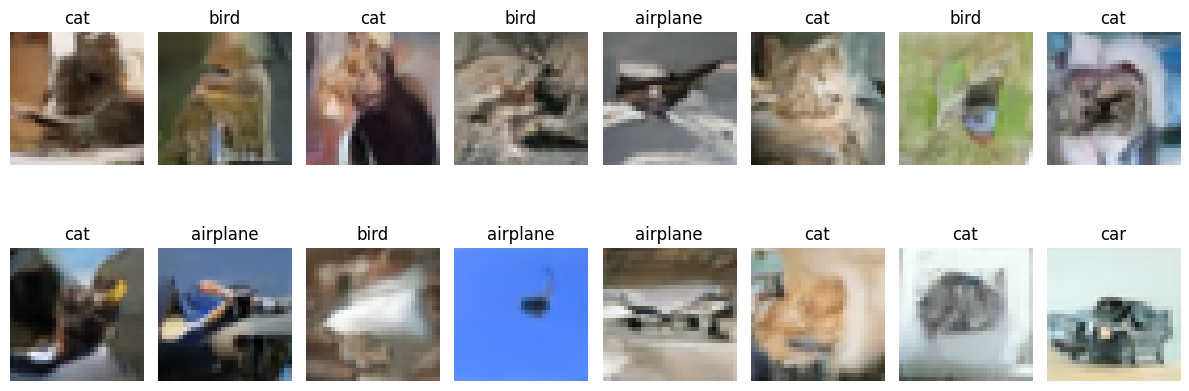

In [34]:
model.plot_images() # Model 2

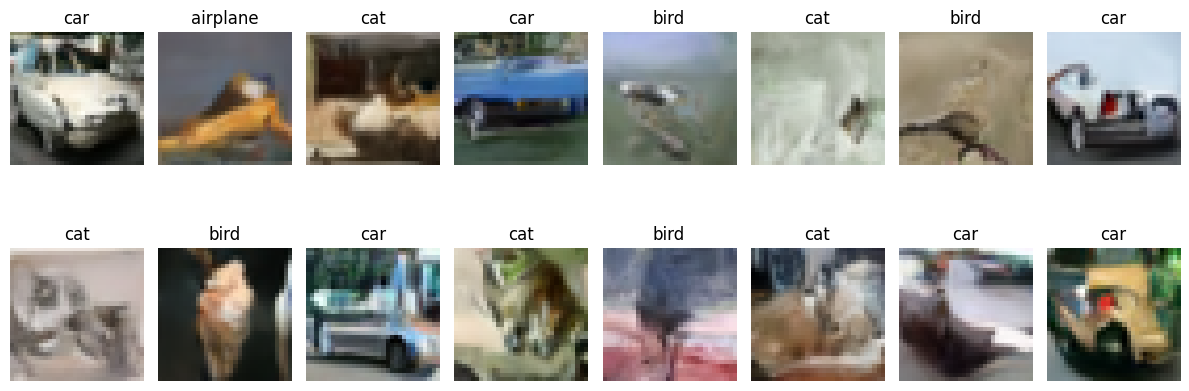

In [35]:
model.plot_images() # Model 2

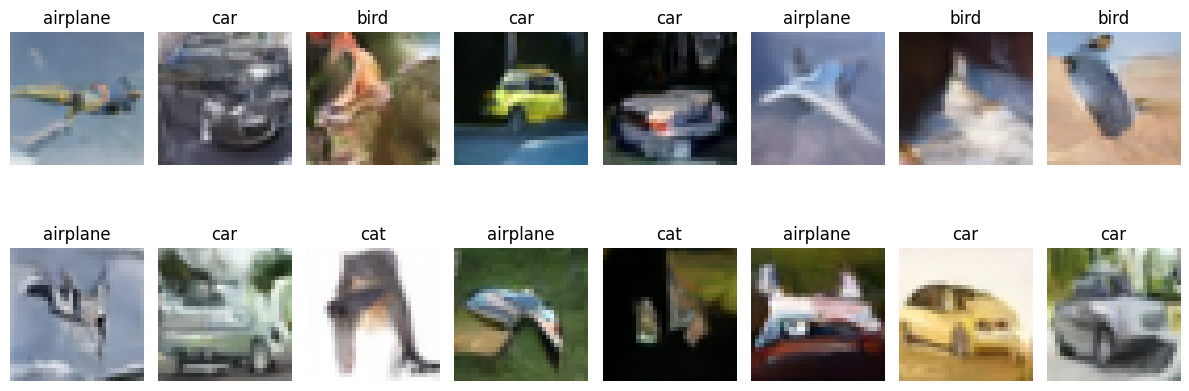

In [36]:
model.plot_images() # Model 2

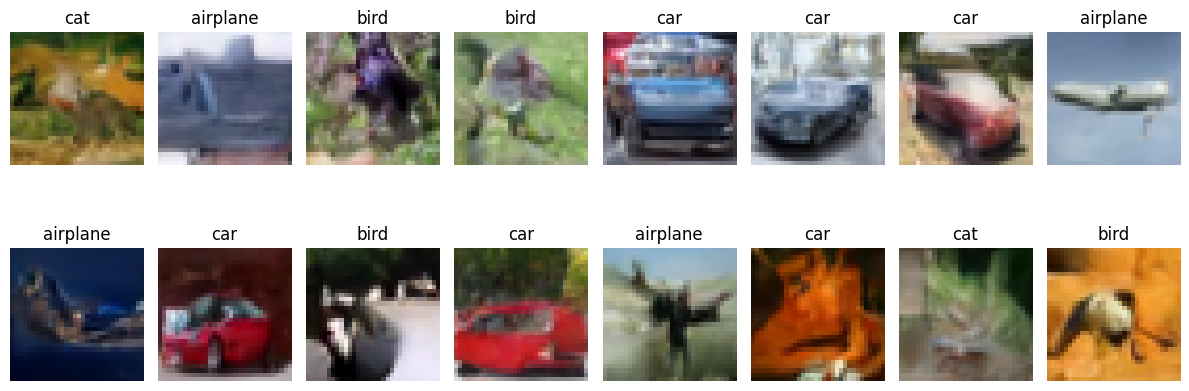

In [37]:
model.plot_images() # Model 2

In [ ]:
model.plot_images()

In [ ]:
model.plot_images()

# File Handling

In [ ]:
# import os

# # Create a directory to save models
# os.makedirs('/kaggle/working/models', exist_ok=True)

# # Train your model
# # (Assuming your model is already trained and stored in the 'model' variable)

# # # Save the model
# # model.ema_network.save('/kaggle/working/models/my_model')


# File Handling

### Create directory

In [ ]:
# os.makedirs('/kaggle/working/dir_name', exist_ok=True)

### Delete a file

In [ ]:
# file_path = "/kaggle/working/state.db"
# os.remove(file_path)

### Delete Directory

In [ ]:
# # Delete an empty directory
# os.rmdir('empty_directory')

# # Delete a directory and its contents
# shutil.rmtree('/kaggle/working/')


### Zip File

In [ ]:
# !zip -r /kaggle/working/working_directory.zip /kaggle/working/* --quiet

### Unzip a file

In [ ]:
# !unzip -q /kaggle/input/your_zip_file.zip -d /kaggle/working/

### Copy folders/directories

In [ ]:
# # Source path
# source_path = '/kaggle/input/basic-diffusion-model-2/kaggle/working'

# # Destination path
# destination_path = '/kaggle/working/'

# # Move the file
# shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
